## Practica 1 - Computer Vision

In [1]:
import os
import gdown

# Crear el directorio de datos si no existe
data_dir = "data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# URL de Google Drive en formato correcto para gdown
url = "https://drive.google.com/uc?id=1iGBv-VT5mm1RiouD-U2qWcU3BYqp2OwE"
zip_filename = "practica_1_dataset.zip"
zip_path = os.path.join(data_dir, zip_filename)

# Descargar el archivo
if not os.path.exists(zip_path):
    gdown.download(url, zip_path, quiet=False)
else:
    print("Data zipfile already exists")


Downloading...
From (original): https://drive.google.com/uc?id=1iGBv-VT5mm1RiouD-U2qWcU3BYqp2OwE
From (redirected): https://drive.google.com/uc?id=1iGBv-VT5mm1RiouD-U2qWcU3BYqp2OwE&confirm=t&uuid=86e37e54-cd3e-4351-9307-3aab10d35895
To: /content/data/practica_1_dataset.zip
100%|██████████| 69.6M/69.6M [00:02<00:00, 31.6MB/s]


In [2]:
import os
from zipfile import ZipFile
from concurrent.futures import ThreadPoolExecutor

data_dir = "data"
zip_filename = "practica_1_dataset.zip"
zip_path = os.path.join(data_dir, zip_filename)
subfolders = ["test", "train", "valid"]
full_paths = [os.path.join(data_dir, folder) for folder in subfolders]

if not all(os.path.isdir(path) for path in full_paths):
    with ZipFile(zip_path, 'r') as zf:
        with ThreadPoolExecutor() as exe:
            for file in zf.namelist():
                if not file.startswith("__MACOSX"):
                    exe.submit(zf.extract, file, path=data_dir)
else:
    print("test, train and valid folders already exist")

In [3]:
import pandas as pd
data_dir = "data"
df = pd.read_csv(os.path.join(data_dir, "test", "annotations.csv"))
print(f"{df.shape = }")
df.head()

df.shape = (584, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,IMG_2526_jpeg_jpg.rf.003e1d1d41bcd204df731b85c...,768,1024,puffin,406,457,497,533
1,IMG_2526_jpeg_jpg.rf.003e1d1d41bcd204df731b85c...,768,1024,puffin,18,705,82,759
2,IMG_2526_jpeg_jpg.rf.003e1d1d41bcd204df731b85c...,768,1024,puffin,51,426,116,475
3,IMG_2526_jpeg_jpg.rf.003e1d1d41bcd204df731b85c...,768,1024,puffin,428,331,504,376
4,IMG_2526_jpeg_jpg.rf.003e1d1d41bcd204df731b85c...,768,1024,puffin,0,613,21,658


In [4]:
import os
import pandas as pd
import numpy as np

def annotation_to_labels(annotations_path):
    # Load the annotations
    df = pd.read_csv(annotations_path)

    # Count the number of instances of each class per image
    count_class = df.groupby(["filename", "class"]).size()

    # Compute the area of each bounding box
    df["area"] = (df["xmax"] - df["xmin"]) * (df["ymax"] - df["ymin"])

    # Compute the area of each class per image
    area_class = df.groupby(["filename", "class"])["area"].sum()

    # Compute the score as AREA * COUNT
    score = pd.Series(area_class * count_class, name="score").reset_index()

    # Group by filename and get the class with the highest score
    df_labels = score.groupby("filename").max().reset_index()

    return df_labels["filename"].values, df_labels["class"].values

data_dir = "data"
filenames, labels = annotation_to_labels(os.path.join(data_dir, "test", "annotations.csv"))
filenames[:5], labels[:5]

(array(['IMG_2289_jpeg_jpg.rf.fe2a7a149e7b11f2313f5a7b30386e85.jpg',
        'IMG_2301_jpeg_jpg.rf.2c19ae5efbd1f8611b5578125f001695.jpg',
        'IMG_2319_jpeg_jpg.rf.6e20bf97d17b74a8948aa48776c40454.jpg',
        'IMG_2347_jpeg_jpg.rf.7c71ac4b9301eb358cd4a832844dedcb.jpg',
        'IMG_2354_jpeg_jpg.rf.396e872c7fb0a95e911806986995ee7a.jpg'],
       dtype=object),
 array(['puffin', 'penguin', 'penguin', 'penguin', 'penguin'], dtype=object))

In [5]:
import shutil
def organize_by_label(filenames, labels, data_dir):
    # Define input and output paths
    filepaths = np.char.add(data_dir + os.sep, filenames)
    organized_filepaths = np.char.add(data_dir + os.sep + labels + os.sep, filenames)

    # Create a directory for each label
    for label in np.unique(labels):
        os.makedirs(data_dir + os.sep + label, exist_ok=True)

    # Move files to their respective directories
    def move_file(src, dest):
        try:
            shutil.move(src, dest)
            return True  # File moved successfully
        except FileNotFoundError:
            if not os.path.exists(dest):
                print(f"Annotated file not found: {src}")
            return False  # File does not exist
        except Exception as e:
            return f"Error: {e}"

    return np.vectorize(move_file)(filepaths, organized_filepaths)

set_names = ["train", "valid", "test"]
for set_name in set_names:
    data_dir = os.path.join("data", set_name)
    filenames, labels = annotation_to_labels(os.path.join(data_dir, "annotations.csv"))
    organize_by_label(filenames, labels, data_dir)

Annotated file not found: data/test/IMG_2434_jpeg_jpg.rf.8b20d3270d4fbc497c64125273f46ecb.jpg


In [6]:
import tensorflow as tf

Example

In [7]:
data_dir = os.path.join("data", "test")
image_paths = tf.data.Dataset.list_files(
    data_dir + os.sep + '*/*.jpg',
    shuffle=False
)  # Note: Pattern only looks inside subfolders
print(image_paths.as_numpy_iterator().next())

b'data/test/fish/IMG_2371_jpeg_jpg.rf.54505f60b6706da151c164188c305849.jpg'


## Create tf.data.Dataset

In [8]:
set_names = ["train", "valid", "test"]
data_dir = "data"
def get_jpg_ds(set_names, data_dir):
    return {
        name: tf.data.Dataset.list_files(
            os.path.join(data_dir, name) + os.sep + '*/*.jpg',
            shuffle=False,
        )
        for name in set_names
    }
ds = get_jpg_ds(set_names, data_dir)
ds

{'train': <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>,
 'valid': <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>,
 'test': <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>}

In [9]:
next(ds["test"].as_numpy_iterator())

b'data/test/fish/IMG_2371_jpeg_jpg.rf.54505f60b6706da151c164188c305849.jpg'

From our tensors that are image paths we extract labels, this is a light weight operation so we keep it in cache and perform all the normalization, that is, convert to onehot encoding

In [10]:
class_mapping = {
    0: b"fish",
    1: b"jellyfish",
    2: b"penguin",
    3: b"puffin",
    4: b"shark",
    5: b"starfish",
    6: b"stingray",
}

class_lookup_table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(list(class_mapping.values())),
        values=tf.constant(list(class_mapping.keys()), dtype=tf.int64)
    ),
    default_value=-1
)

def get_label(image_path):
    label = tf.strings.split(image_path, os.sep)[-2]
    label = class_lookup_table.lookup(label)
    label = tf.one_hot(label, len(class_mapping))
    return label

def update_ds(ds, func):
    for key in ds.keys():
        ds[key] = ds[key].map(
            func,
            num_parallel_calls=tf.data.AUTOTUNE
        )

set_names = ["train", "valid", "test"]
data_dir = "data"

ds = get_jpg_ds(set_names, data_dir)
update_ds(ds, lambda x: (x, get_label(x)))

ds["test"].as_numpy_iterator().next()

(b'data/test/fish/IMG_2371_jpeg_jpg.rf.54505f60b6706da151c164188c305849.jpg',
 array([1., 0., 0., 0., 0., 0., 0.], dtype=float32))

In [11]:
def get_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


ds = get_jpg_ds(set_names, data_dir)
update_ds(ds, lambda x: (x, get_label(x)))
update_ds(ds, lambda x, y: (get_image(x), y))

ds

{'train': <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'valid': <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'test': <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>}

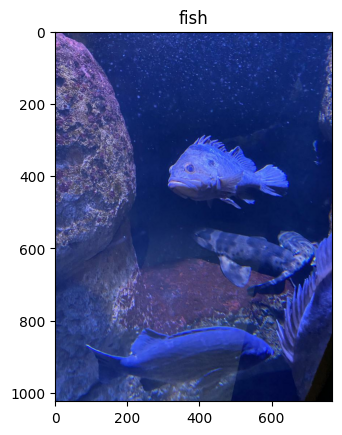

In [12]:
import matplotlib.pyplot as plt

image, label = next(ds["test"].as_numpy_iterator())

plt.imshow(image)
plt.title(class_mapping[np.argmax(label)].decode())
plt.show()

In [13]:
ds = get_jpg_ds(set_names, data_dir)
update_ds(ds, lambda x: (x, get_label(x)))
update_ds(ds, lambda x, y: (get_image(x), y))
update_ds(ds, lambda x, y: (tf.image.resize_with_crop_or_pad(x, 1024, 1024), y))

ds

{'train': <_ParallelMapDataset element_spec=(TensorSpec(shape=(1024, 1024, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'valid': <_ParallelMapDataset element_spec=(TensorSpec(shape=(1024, 1024, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'test': <_ParallelMapDataset element_spec=(TensorSpec(shape=(1024, 1024, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>}

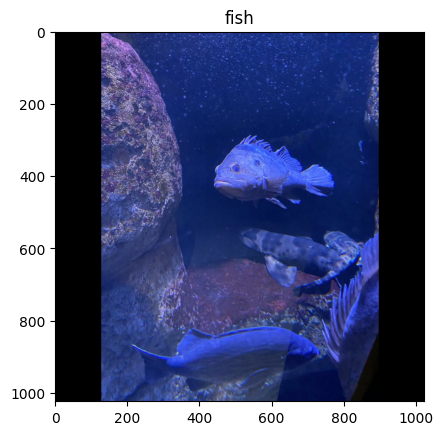

In [14]:
import matplotlib.pyplot as plt

image, label = next(ds["test"].as_numpy_iterator())

plt.imshow(image)
plt.title(class_mapping[np.argmax(label)].decode())
plt.show()

In [93]:
def resize_and_keep_uint8(image, height=64, width=64):
    resized_image = tf.image.resize(image, [height, width])  # Resize
    resized_image = tf.clip_by_value(resized_image, 0, 255)  # Ensure values remain valid
    resized_image = tf.cast(resized_image, tf.uint8)  # Convert back to uint8
    return resized_image

ds = get_jpg_ds(set_names, data_dir)
update_ds(ds, lambda x: (x, get_label(x)))
update_ds(ds, lambda x, y: (get_image(x), y))
update_ds(ds, lambda x, y: (tf.image.resize_with_crop_or_pad(x, 1024, 1024), y))
update_ds(ds, lambda x, y: (resize_and_keep_uint8(x), y))

ds

{'train': <_ParallelMapDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'valid': <_ParallelMapDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'test': <_ParallelMapDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>}

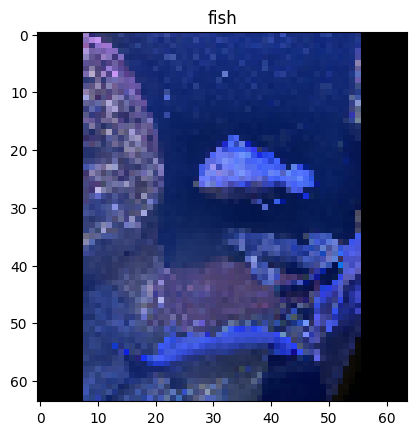

In [94]:
import matplotlib.pyplot as plt

image, label = next(ds["test"].as_numpy_iterator())

plt.imshow(image)
plt.title(class_mapping[np.argmax(label)].decode())
plt.show()

In [95]:
ds = get_jpg_ds(set_names, data_dir)
update_ds(ds, lambda x: (x, get_label(x)))
update_ds(ds, lambda x, y: (get_image(x), y))
update_ds(ds, lambda x, y: (tf.image.resize_with_crop_or_pad(x, 1024, 1024), y))
update_ds(ds, lambda x, y: (resize_and_keep_uint8(x), y))

ds

{'train': <_ParallelMapDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'valid': <_ParallelMapDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>,
 'test': <_ParallelMapDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(7,), dtype=tf.float32, name=None))>}

In [96]:
print(len(ds["train"]), len(ds["valid"]))

def augment(image,label):
    image = tf.image.random_flip_left_right(image) # Random flip horizontal
    return image, label

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
ds_fit = (
    ds["train"]
    .cache()
    .map(augment, num_parallel_calls=AUTOTUNE)
    .shuffle(len(ds["train"]))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

ds_val = (
    ds["valid"]
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

447 127


In [97]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0001)

epoch_wait = 10
# Crear el EarlyStopping callback con la función on_train_end
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=epoch_wait, restore_best_weights=True)

# Definimos los callbacks
callbacks = [early_stopping, reduce_lr]

In [98]:
# Establecer la semilla global
seed_value = 42
tf.random.set_seed(seed_value)

In [141]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, ZeroPadding2D
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNetV2, InceptionV3, ResNet50, VGG16, VGG19, DenseNet121, DenseNet169, DenseNet201
# Regularizer
l2_reg_strength = 0.01
num_classes = 7


model = Sequential([
    # tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Flips aleatorios en ambas direcciones
    # tf.keras.layers.RandomRotation(0.2),  # Rotación aleatoria (20% del rango completo)
    #tf.keras.layers.RandomZoom(0.2),  # Zoom aleatorio hasta un 20%
    #tf.keras.layers.RandomContrast(0.2),  # Variación en contraste
    #tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Desplazamiento aleatorio (shifts)
    # base_model,
    ZeroPadding2D(padding=(4, 4)),
    Conv2D(32, (3, 3), activation='relu'),

    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(l2_reg_strength)),
    MaxPooling2D((4, 4)),
    Dropout(0.25),

    BatchNormalization(),
    ZeroPadding2D(padding=(2, 2)),
    Conv2D(128, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(l2_reg_strength)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Hacemos una copia del modelo, con los mismos pesos y la misma arquitectura
model_test = tf.keras.models.clone_model(model)


# Compilar el modelo
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=[
                  "accuracy",
                  "precision",
                  "recall",
                  # "f1_score"
                  # tf.keras.metrics.Accuracy(name='accuracy'),
                  # tf.keras.metrics.Precision(name='precision'),
                  # tf.keras.metrics.Recall(name='recall'),
                  # tf.keras.metrics.F1Score(name='f1_score')
              ])

# Entrenar el modelo utilizando el conjunto de datos
history = model.fit(ds_fit, epochs=100, validation_data=ds_val, callbacks=callbacks)

import numpy as np

best_epoch = np.argmax(history.history["val_accuracy"])  # Índice de la mejor val_accuracy
best_val_acc = history.history["val_accuracy"][best_epoch]

print(f"La mejor época fue: {best_epoch + 1} con val_accuracy: {best_val_acc:.4f}")

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 461ms/step - accuracy: 0.3776 - loss: 3.6372 - precision: 0.4084 - recall: 0.3309 - val_accuracy: 0.1890 - val_loss: 12.0708 - val_precision: 0.1840 - val_recall: 0.1811 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.6270 - loss: 2.4338 - precision: 0.6877 - recall: 0.5119 - val_accuracy: 0.1575 - val_loss: 11.1152 - val_precision: 0.1639 - val_recall: 0.1575 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6757 - loss: 2.1269 - precision: 0.7244 - recall: 0.6305 - val_accuracy: 0.3071 - val_loss: 10.6184 - val_precision: 0.3040 - val_recall: 0.2992 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7252 - loss: 2.0098 - precision: 0.7652 - recall: 0.6742 - val_accuracy: 0.4252 - val_loss: 5.0299 - val_precision: 0.4444 - val_recall: 0.4094 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accu

In [156]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, ZeroPadding2D, RandomRotation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential

def build_model(conv_sizes, kernel_sizes, pooling_sizes, n_convs, lr_patience, num_classes):
  # Callbacks for learning rate and iterations
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=lr_patience, min_lr=0.0001)
  early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=10, restore_best_weights=True)
  callbacks = [early_stopping, reduce_lr]

  input_layers = [ZeroPadding2D(padding=(4, 4))]

  hidden_layers = []
  for i in range(n_convs):
      hidden_layers.append(Conv2D(conv_sizes[i], kernel_sizes[i], activation='relu'))
      hidden_layers.append(BatchNormalization())
      if pooling_sizes[i] is not None:
        hidden_layers.append(MaxPooling2D(pooling_sizes[i]))
      hidden_layers.append(Dropout(0.25))

  output_layers = [
      Flatten(),
      Dense(512, activation='relu'),
      BatchNormalization(),
      Dropout(0.5),
      Dense(num_classes, activation='softmax')
  ]
  model = Sequential(input_layers + hidden_layers + output_layers)


  # Compile with categorical crossentropy and RMSprop
  model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=[
      "accuracy",
      "precision",
      "recall",
    ]
  )

  return model


In [157]:
conv_sizes = [32, 64, 128, 128]
kernel_sizes = [(3, 3), (4, 4), (3, 3), (3, 3)]
pooling_sizes = [None, (4, 4), None, (2, 2)]
n_convs = len(kernel_sizes)
lr_patience = 10
num_classes = 7
model = build_model(conv_sizes, kernel_sizes, pooling_sizes, n_convs, lr_patience, num_classes)
history = model.fit(ds_fit, epochs=100, validation_data=ds_val, callbacks=callbacks)
best_val_acc = history.history["val_accuracy"][np.argmax(history.history["val_accuracy"])]

print(f"La mejor época fue: {best_epoch + 1} con val_accuracy: {best_val_acc:.4f}")

[<ZeroPadding2D name=zero_padding2d_52, built=False>, <Conv2D name=conv2d_498, built=False>, <BatchNormalization name=batch_normalization_525, built=False>, <Dropout name=dropout_132, built=True>, <Conv2D name=conv2d_499, built=False>, <BatchNormalization name=batch_normalization_526, built=False>, <MaxPooling2D name=max_pooling2d_97, built=True>, <Dropout name=dropout_133, built=True>, <Conv2D name=conv2d_500, built=False>, <BatchNormalization name=batch_normalization_527, built=False>, <Dropout name=dropout_134, built=True>, <Conv2D name=conv2d_501, built=False>, <BatchNormalization name=batch_normalization_528, built=False>, <MaxPooling2D name=max_pooling2d_98, built=True>, <Dropout name=dropout_135, built=True>, <Flatten name=flatten_48, built=False>, <Dense name=dense_95, built=False>, <BatchNormalization name=batch_normalization_529, built=False>, <Dropout name=dropout_136, built=True>, <Dense name=dense_96, built=False>]
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 699ms/step - ac

In [105]:
BATCH_SIZE = 64
ds_eval = (
    ds["test"].cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
#test_loss, test_acc
metrics = model.evaluate(ds_eval)

print('Test metrics:', metrics)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7581 - loss: 1.2801 - precision: 0.7797 - recall: 0.7419
Test metrics: [1.2801228761672974, 0.7580645084381104, 0.7796609997749329, 0.7419354915618896]


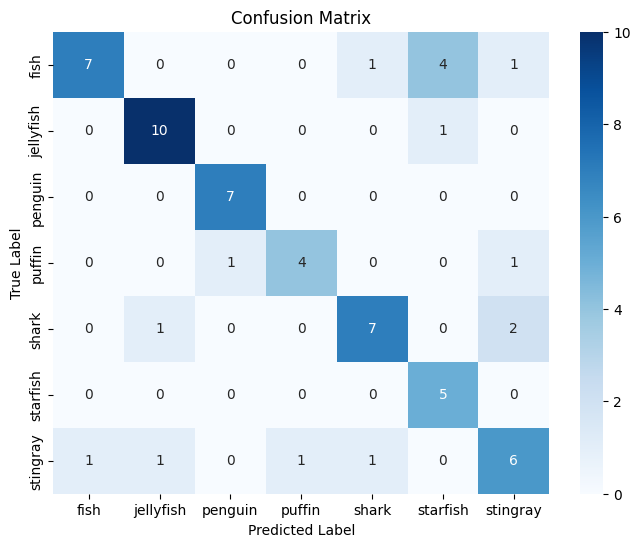

In [101]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get all images and labels in a single batch
y_true = np.concatenate([y.numpy() for _, y in ds_eval])
y_pred = np.concatenate([model.predict(x, verbose=0) for x, _ in ds_eval])

# Convert from one-hot encoding to class indices
y_true = np.argmax(y_true, axis=1)
y_pred = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

label_names = [class_mapping[i].decode() for i in range(7)]
# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

```python
AUTOTUNE = tf.data.AUTOTUNE

ds_files = tf.data.Dataset.list_files("data/test/" + '*.jpg', shuffle=False)
df = pd.read_csv("data/test/annotations.csv")
df["class"] = pd.Categorical(df["class"])
ds_images = (
    ds_files
    .shuffle(len(ds_files))
    .cache()
    .map(lambda x: (get_image(x), get_label(x, df)), num_parallel_calls=AUTOTUNE)
)

print("Total images:", len(ds_images))
print("Image shape:", ds_images.element_spec)